In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt


In [2]:
## determine use gpu or cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

if device == 'cpu' :
    ## number of gpu
    n_gpu = torch.cuda.device_count()
    print(n_gpu)

    ## name of current device
    device_name = torch.cuda.get_device_name(0)
    print(device_name)

cuda


In [3]:
! nvidia-smi

Wed Jun  5 22:14:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!wget https://raw.githubusercontent.com/ArmanArabi/Fine-Tunning-Bert-model/main/in_domain_train.tsv


In [5]:
import os
!curl -L https://raw.githubusercontent.com/ArmanArabi/Fine-Tunning-Bert-model/main/in_domain_train.tsv


Streaming output truncated to the last 5000 lines.
ks08	1		he treats john very kindly .
ks08	0	*	he treats john very kind .
ks08	0	*	he treats john very shame .
ks08	1		he walked right into the wall .
ks08	0	*	he walked right happy .
ks08	0	*	he walked right the wall .
ks08	1		john sang a song , mary played the piano .
ks08	1		we found out that very lucrative jobs were in jeopardy .
ks08	0	*	my these jobs are in jeopardy .
ks08	0	*	the his jobs are in jeopardy .
ks08	1		i think learning english is not easy at all .
ks08	1		i doubt you can help me in understanding this .
ks08	1		i think that learning english is not all that easy .
ks08	1		i doubt if you can help me in understanding this .
ks08	1		i am anxious for you to study english grammar hard .
ks08	0	*	i think that learning english to be not all that easy .
ks08	0	*	i doubt if you to help me in understanding this .
ks08	0	*	i am anxious for you should study english grammar hard .
ks08	1		john not leave .
ks08	1		john drink beer las

In [6]:
df = pd.read_csv("/content/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df.shape

(8551, 4)

In [7]:
df.columns

Index(['sentence_source', 'label', 'label_notes', 'sentence'], dtype='object')

In [8]:
print(df['sentence'][0])
print(df['label'][0])

our friends wo n't buy this analysis , let alone the next one we propose .
1


In [9]:
## Preparing the pretraining input(next seq prediction or NSP)
sentences = df.sentence.values
sentences = ["[CLS]" + sentence + "[SEP]" for sentence in sentences]
labels = df.label.values

In [10]:
type(sentences)
print(sentences[0])

[CLS]our friends wo n't buy this analysis , let alone the next one we propose .[SEP]


In [11]:
## Activating the BERT Tokenizer

# from transformer import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True )
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokenize the first sentence:
['[CLS]', 'our', 'friends', 'wo', 'n', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']




```
# preprocess data :

1- first check the maximum size of sentences len in our dataset

2- need to determine a fixed maximum length and process the data for the model
```



In [12]:
max_len = 0
for sen in tokenized_texts :
    count = len(sen)
    if count> max_len :
        max_len=count
print(max_len)

## the longest is 47. in the orginal paper is 512.
MAX_LEN = 128

## Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
print(f'input_ids[0] : {input_ids[0]}')

## Pad our input tokens
# from keras.preprocecing.sequence
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', truncating='post', padding='post')
print(f'input_ids[0] after padding : {input_ids[0]}')


47
input_ids[0] : [101, 2256, 2814, 24185, 1050, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012, 102]
input_ids[0] after padding : [  101  2256  2814 24185  1050  1005  1056  4965  2023  4106  1010  2292
  2894  1996  2279  2028  2057 16599  1012   102     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]


In [13]:
## Create attention masks
## Create a mask of 1s for each token followed by 0s for padding
attention_masks = []

for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

print(f"attention_masks[0] : {attention_masks[0]} " )

attention_masks[0] : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 




```
# in this step should convert to torch and be ready to set the model
```



In [14]:
## title Splitting data into train and validation sets
## Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids,
                                            labels, random_state=2018, test_size=0.1)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [15]:
## convert data to torch tensor
## Torch tensors are the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [16]:
##Selecting a Batch Size and Creating and Iterator
##For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
BATCH_SIZE = 32

##Create an iterator of our data with torch DataLoader. This helps save on memory during training because :
    ##unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory

# from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
train_data = TensorDataset(train_inputs , train_masks , train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data , batch_size=BATCH_SIZE , sampler=train_sampler)

validation_data = TensorDataset(validation_inputs , validation_masks , validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data , batch_size=BATCH_SIZE , sampler=validation_sampler)

In [17]:
##Bert Configuration :

## Initializing a BERT bert-base-uncased style configuration
try:
    import transformers
except:
    print("Installing transformers")
    !pip -qq install transformers

from transformers import BertModel, BertConfig


## Initializing a model from the bert-base-uncased style configuration

#configuration = BertModel(BertConfig()).config
configuration = BertConfig()
model = BertModel(configuration)
## Accessing the model configuration
configuration = model.config
print(configuration)



BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.41.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [18]:
##Loading the Hugging Face Bert Uncased Base Model

# from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model = nn.DataParallel(model)
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DataParallel(
  (module): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=7

In [19]:
[print(i) for i in model.named_parameters()]

Streaming output truncated to the last 5000 lines.
         2.3162e-02, -6.5850e-03, -4.5545e-03, -1.3545e-02, -3.3110e-03,
         1.2560e-02, -1.8602e-02, -8.0113e-03,  7.2269e-03, -2.9990e-02,
        -2.8031e-02, -1.7690e-02, -1.5990e-02, -4.3190e-03,  5.8396e-03,
         2.2739e-02, -1.1243e-02, -2.3899e-02, -9.9552e-03, -3.2969e-03,
         2.5843e-04, -5.0730e-03, -1.7659e-02, -2.7961e-02, -3.1366e-02,
        -3.4438e-02, -1.9468e-02,  8.3128e-03,  1.5317e-02, -1.7636e-02,
        -3.9919e-03, -3.8846e-03,  1.1868e-03, -6.3348e-03,  2.9717e-02,
        -5.9271e-03, -2.4939e-02,  9.1898e-03, -6.9647e-03,  7.7740e-02,
         8.2349e-03, -1.8818e-03, -2.0718e-02, -3.8484e-02,  2.0732e-02,
        -1.1053e-02, -1.8700e-02,  3.6481e-02,  1.5331e-02, -9.2603e-03,
         3.8407e-02,  1.4102e-02, -4.8100e-02,  8.3475e-03, -2.5904e-02,
        -1.7927e-02,  4.1530e-04, -2.4523e-02,  7.8518e-03,  2.7492e-02,
        -1.4832e-03,  4.7044e-03, -3.0004e-02, -3.1918e-02, -2.3863e-03,


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [20]:
## Optimizer Grouped Parameters

##This code is taken from: https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L102
## Don't apply weight decay to any parameters whose names include these tokens.
## (Here, the BERT doesn't have `gamma` or `beta` parameters, only `bias` terms)

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']
'''
for n,p in param_optimizer:
    print(n)
    print('------')
    print(p)
    print('/////////////////////////')
'''

## Separate the `weight` parameters from the `bias` parameters.
## - For the `weight` parameters, this specifies a 'weight_decay_rate'= 0.01
## - For the `bias` parameters, the 'weight_decay_rate'= 0.0
## `optimizer_grouped_parameters` only includes the parameter values, not the names.
optimizer_grouped_parameters = [
    # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.1},

    # Filter for parameters which *do* include those.
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [21]:
## The Hyperparemeters for the Training Loop :


optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5, eps = 1e-8)

## Number of training epochs (authors recommend between 2 and 4)
epochs = 4

## Total number of training steps is number of batches * number of epochs.
## `train_dataloader` contains batched data so `len(train_dataloader)` gives the number of batches.
total_steps = len(train_dataloader) * epochs

## Create the learning rate scheduler.
# from transformer import get_linear_schedule_with_warmup
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


##Creating the Accuracy Measurement Function
## Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(




```
# The Training Loop

```



In [22]:
t = []

## Store our loss and accuracy for plotting
train_loss_set = []

for _ in trange(epochs, desc="Epoch"):
  model.train()

  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0

  ## Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    #print(f'the number of step is :{step}')>> 240 batch size with size 32
    ## Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    ## Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    ## Forward pass
    optimizer.zero_grad()
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs['loss']
    train_loss_set.append(loss.item())
    ## Backward pass
    loss.backward()
    ## Update parameters and take a step using the computed gradient
    optimizer.step()
    ## Update the learning rate.
    scheduler.step()

    ## Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))



  ## Validation
  model.eval()

  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  ## Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    ## Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
        ## Forward pass, calculate logit predictions
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    print(f' the logit is : {logits}')
    ## Move logits and labels to CPU
    logits = logits['logits'].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.5065358272479283
 the logit is : SequenceClassifierOutput(loss=None, logits=tensor([[ 1.1496, -0.4891],
        [-0.3212,  0.9449],
        [-0.5814,  1.2905],
        [-1.4652,  1.7141],
        [-0.5965,  0.9719],
        [-0.0207,  0.5743],
        [-1.4689,  1.9538],
        [ 0.7399, -0.1618],
        [ 1.0658, -0.5665],
        [-0.2707,  0.6933],
        [-0.9951,  1.6187],
        [-0.9176,  1.3990],
        [-1.5336,  1.9408],
        [-0.2321,  0.8497],
        [-1.5718,  1.9757],
        [-0.5059,  1.0435],
        [ 0.4128,  0.2009],
        [-0.8255,  1.4669],
        [ 0.4359,  0.3106],
        [-0.8598,  1.3869],
        [-1.2646,  1.7048],
        [-0.6959,  1.3138],
        [-1.4680,  2.0384],
        [-1.3028,  1.9741],
        [ 1.1646, -0.6651],
        [-0.5255,  1.2023],
        [-0.8882,  1.4623],
        [-1.1116,  1.7769],
        [-0.5076,  1.0083],
        [-1.5778,  1.9690],
        [-0.7237,  1.3342],
        [-1.4442,  2.0452]], device='cuda:

Epoch:  25%|██▌       | 1/4 [02:29<07:27, 149.32s/it]

 the logit is : SequenceClassifierOutput(loss=None, logits=tensor([[ 0.9449, -0.2707],
        [-0.7315,  1.4276],
        [-1.2606,  1.7806],
        [ 0.2448,  0.3675],
        [ 1.0933, -0.5442],
        [-0.0982,  0.6318],
        [-1.5515,  1.9130],
        [-0.2275,  0.6708],
        [-1.6599,  2.0413],
        [-0.8404,  1.4252],
        [ 0.6114,  0.1114],
        [-0.2309,  0.7668],
        [ 0.0094,  0.4508],
        [-0.2512,  0.8391],
        [ 0.8609, -0.3326],
        [-0.9353,  1.4885],
        [-0.1827,  0.6094],
        [-1.2283,  1.8359],
        [-1.4998,  1.9440],
        [ 0.2128,  0.5907],
        [-0.9085,  1.3898],
        [-1.3430,  1.8307],
        [-1.2329,  1.6324],
        [-0.8196,  1.2860],
        [ 0.4449,  0.2848],
        [ 0.0886,  0.4959],
        [-1.3734,  1.9819],
        [ 0.0293,  0.4999],
        [ 0.3195,  0.3730],
        [ 0.7490,  0.1372],
        [-1.0723,  1.8940],
        [-0.3017,  0.9205]], device='cuda:0'), hidden_states=None, attent

Epoch:  50%|█████     | 2/4 [05:07<05:08, 154.29s/it]

 the logit is : SequenceClassifierOutput(loss=None, logits=tensor([[ 1.4409, -1.3705],
        [-0.9536,  1.5571],
        [-1.7485,  2.1416],
        [ 0.6941, -0.2531],
        [ 1.6136, -1.8456],
        [ 0.3944,  0.0801],
        [-1.8078,  2.2860],
        [-0.8091,  1.1802],
        [-1.9600,  2.3765],
        [-1.1891,  1.7148],
        [ 1.1359, -0.7718],
        [-0.0906,  0.4755],
        [ 0.5353, -0.3116],
        [-0.4803,  0.8572],
        [ 1.0858, -0.9816],
        [-0.0922,  0.4539],
        [-0.6964,  0.8994],
        [-1.5190,  2.0106],
        [-1.5982,  2.1146],
        [ 0.0954,  0.5935],
        [-1.1666,  1.5448],
        [-1.8083,  2.1948],
        [-1.4846,  1.9041],
        [-0.8822,  1.2694],
        [ 0.7637, -0.2794],
        [-0.4529,  0.8076],
        [-1.9401,  2.4189],
        [ 1.0478, -0.9718],
        [ 0.3527,  0.2073],
        [ 0.8536, -0.1278],
        [-1.5640,  2.3004],
        [-1.6361,  2.2321]], device='cuda:0'), hidden_states=None, attent

Epoch:  75%|███████▌  | 3/4 [07:47<02:37, 157.13s/it]

 the logit is : SequenceClassifierOutput(loss=None, logits=tensor([[ 2.0749, -2.5020],
        [-1.2071,  1.8561],
        [-2.2936,  2.6424],
        [ 0.8320, -0.4246],
        [ 2.0597, -2.6008],
        [ 0.8665, -0.5440],
        [-2.3442,  2.7845],
        [-1.6040,  1.8713],
        [-2.4591,  2.8786],
        [-1.8858,  2.4056],
        [ 1.1174, -0.8089],
        [-0.7842,  1.1609],
        [ 1.6746, -2.1916],
        [-0.8773,  1.2384],
        [ 1.8707, -2.3872],
        [-1.2641,  1.6459],
        [-1.4623,  1.6135],
        [-2.2063,  2.7467],
        [-2.2347,  2.7102],
        [-0.6077,  1.3652],
        [-1.8841,  2.2539],
        [-2.3604,  2.7006],
        [-2.1667,  2.5830],
        [-1.3456,  1.7841],
        [ 0.8338, -0.3556],
        [-0.6701,  0.9706],
        [-2.4435,  2.8429],
        [ 1.4928, -1.8312],
        [ 0.2147,  0.3597],
        [ 0.8037, -0.0860],
        [-2.0614,  2.8094],
        [-2.1037,  2.6887]], device='cuda:0'), hidden_states=None, attent

Epoch: 100%|██████████| 4/4 [10:28<00:00, 157.16s/it]

 the logit is : SequenceClassifierOutput(loss=None, logits=tensor([[ 2.2875, -2.9416],
        [-1.4415,  2.1151],
        [-2.4415,  2.7395],
        [ 1.0677, -0.7926],
        [ 2.2810, -2.8993],
        [ 1.1811, -0.9806],
        [-2.5466,  2.9470],
        [-2.0956,  2.4087],
        [-2.5639,  2.9345],
        [-2.3849,  2.8338],
        [ 1.1392, -0.9097],
        [-1.4443,  1.8300],
        [ 1.9550, -2.7038],
        [-1.7766,  2.1257],
        [ 2.1590, -2.8152],
        [-1.4583,  1.8037],
        [-2.1617,  2.2540],
        [-2.5076,  2.9987],
        [-2.4917,  2.9153],
        [-1.4980,  2.1800],
        [-2.4459,  2.7135],
        [-2.5455,  2.8907],
        [-2.5096,  2.9251],
        [-1.9236,  2.3773],
        [ 1.0269, -0.6266],
        [-1.3278,  1.5378],
        [-2.4794,  2.7992],
        [ 1.7625, -2.3567],
        [-0.1507,  0.7282],
        [ 0.6723,  0.0201],
        [-2.4175,  3.0769],
        [-2.3754,  2.8419]], device='cuda:0'), hidden_states=None, attent

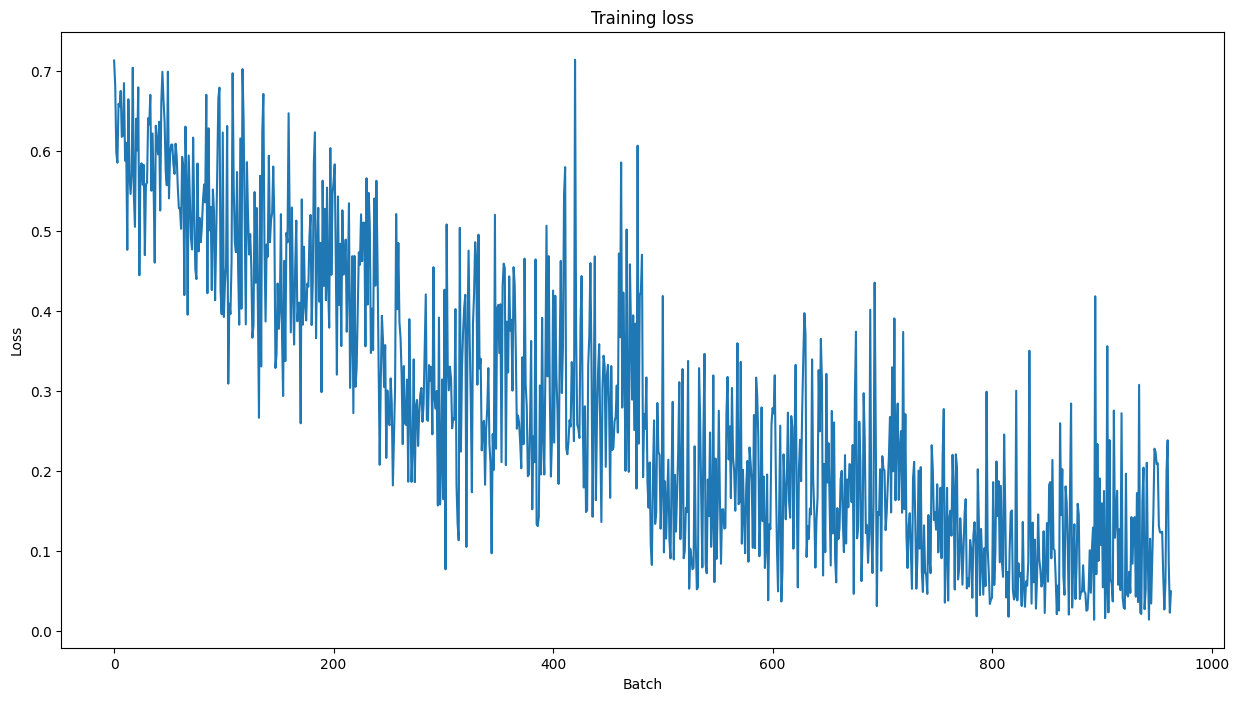

In [23]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()




```
 predicti modek ( text data )
```



In [24]:
! wget https://raw.githubusercontent.com/ArmanArabi/Fine-Tunning-Bert-model/main/out_of_domain_dev.tsv


--2024-06-05 22:25:04--  https://raw.githubusercontent.com/PacktPublishing/Transformers-for-Natural-Language-Processing/main/Chapter02/out_of_domain_dev.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28506 (28K) [text/plain]
Saving to: ‘out_of_domain_dev.tsv’

out_of_domain_dev.t 100%[===================>]  27.84K  --.-KB/s    in 0s      

2024-06-05 22:25:04 (125 MB/s) - ‘out_of_domain_dev.tsv’ saved [28506/28506]



In [25]:
df_test = pd.read_csv('/content/out_of_domain_dev.tsv', delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df_test.shape

(516, 4)

In [26]:
sentences = df_test.sentence.values
sentences = ["[CLS]" + sentence + "[SEP]" for sentence in sentences]
labels = df_test.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

MAX_LEN = 128

## Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
## Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, padding="post", truncating="post", dtype="long" )

## Create attention masks
attention_masks = []
## Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
# Print the shapes of the tensors
print(f'prediction_inputs shape is: {prediction_inputs.shape}')
print(f'prediction_masks shape is: {prediction_masks.shape}')
print(f'prediction_labels shape is: {prediction_labels.shape}')

assert prediction_inputs.shape[0] == prediction_masks.shape[0] == prediction_labels.shape[0], "Size mismatch between tensors"

batch_size = 32
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

prediction_inputs shape is: torch.Size([516, 128])
prediction_masks shape is: torch.Size([516, 128])
prediction_labels shape is: torch.Size([516])


In [27]:
## Prediction on test set

## Put model in evaluation mode
model.eval()
## Tracking variables
predictions , true_labels = [], []

for batch in prediction_dataloader :
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    print(logits)
    logits = logits['logits'].detach().cpu().numpy()
    print('///////////////')
    print(logits)
    label_ids = b_labels.to('cpu').numpy()
    predictions.append(logits)
    true_labels.append(label_ids)


SequenceClassifierOutput(loss=tensor(1.5943, device='cuda:0'), logits=tensor([[-2.3667,  2.9888],
        [-2.3246,  2.6590],
        [-2.4487,  2.8577],
        [-2.4447,  2.8526],
        [-1.4764,  2.1848],
        [-2.5237,  2.9601],
        [-1.3542,  1.7693],
        [-1.9355,  2.3478],
        [-2.5263,  2.9035],
        [-2.2986,  2.5245],
        [-1.5651,  2.1208],
        [ 0.5683, -0.1312],
        [-2.4480,  2.6592],
        [-1.1518,  1.6725],
        [-1.8069,  2.4435],
        [-1.6855,  1.9718],
        [-1.9521,  2.3329],
        [ 2.2268, -2.8820],
        [-2.0459,  2.5436],
        [-1.5197,  2.2030],
        [-2.0459,  2.5436],
        [-1.4892,  1.9869],
        [-1.6769,  2.1783],
        [-1.4759,  2.1160],
        [-0.8445,  1.5363],
        [-2.4340,  2.7424],
        [-2.0391,  2.5215],
        [-2.2652,  2.7129],
        [-2.2498,  2.7703],
        [-2.1059,  2.4399],
        [-2.2979,  2.6946],
        [-1.6741,  2.0105]], device='cuda:0'), hidden_states=N

In [28]:
len(true_labels)

17

In [29]:
##Evaluating Using Matthew's Correlation Coefficient

# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
    matthews = matthews_corrcoef(true_labels[i], np.argmax(predictions[i], axis=1).flatten())
    matthews_set.append(matthews)

matthews_set


[0.049286405809014416,
 -0.21684543705982773,
 0.4040950971038548,
 0.23372319715296222,
 0.21867346044008387,
 0.6777932975034471,
 0.3768673314407159,
 0.0,
 0.8320502943378436,
 0.7704873741021288,
 0.8459051693633014,
 0.647150228929434,
 0.7562449037944323,
 0.7141684885491869,
 0.3268228676411533,
 0.5056936741642399,
 0.0]

In [30]:
##Matthew's Evaluation on the Whole Dataset

# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]
matthews_corrcoef(flat_true_labels, flat_predictions)

0.4928725187819344

In [33]:
## calcute MCC manually

FP = np.array(flat_predictions)
FTL = np.array(flat_true_labels)

TP = np.sum( (FP == 1) & (FTL == 1) )
TN = np.sum( (FP == 0) & (FTL == 0) )
FP = np.sum( (FP == 1) & (FTL == 0) )
FN = np.sum( (FP == 0) & (FTL == 1) )
print(f'TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}')


numerator = (TP * TN) - (FP * FN)
denominator = np.sqrt( (TP + FP) * (TN + FN) * (TP + FN) * (TN + FP)  )

if denominator==0 :
    MCC = 0
else :
    MCC = numerator / denominator
print(MCC)

TP: 330, TN: 80, FP: 82, FN: 0
0.628920640653653
